# Experiment1
As the first step, I just tried nine default scenarios:  
'simple', 'simple_adversary', 'simple_crypto','simple_push',   
'simple_reference', 'simple_speaker_listener', 'simple_spread',  
'simple_tag', 'simple_world_comm'

with the default parameters:

#### Env pars
- parser.add_argument("--max-episode-len", type=int, default=25, help="maximum episode length")
- parser.add_argument("--num-episodes", type=int, default=60000, help="number of episodes")
- parser.add_argument("--num-adversaries", type=int, default=0, help="number of adversaries")
- parser.add_argument("--good-policy", type=str, default="maddpg", help="policy for good agents")
- parser.add_argument("--adv-policy", type=str, default="maddpg", help="policy of adversaries")

#### Learning pars
- parser.add_argument("--lr", type=float, default=1e-2, help="learning rate for Adam optimizer")
- parser.add_argument("--gamma", type=float, default=0.95, help="discount factor")
- parser.add_argument("--batch-size", type=int, default=1024, help="number of episodes to optimize at the same time")
- parser.add_argument("--num-units", type=int, default=64, help="number of units in the mlp")


#### Resulting data
- maddpg/experiments/exp_results/gmoapp/
    - the same setup were tried at gpu_jk/; here we use gmoapp.

## Summary of the results

-  In 5 scenarios with the above defulat setup, the agents learn the expected behaviros:
    - simple,  adversary,  push,  spread, speaker_listener
- The rest seems something wrong as below.
    - tag
        - max_len_epi of 25 seems short
    - world_comm
        - max_len_epi of 25 seems short
    - crypto
        - I couldn't display the results so that I don't know the training is properly completed.
    - reference
        - It seems no learning. I'm not sure why.


## Next step
- tag
    - try to extend max_epi_len (-> exp2)
        - The model is updated by every some steps (not episodes)
        - -> When I extend the max_epi_len, total training episodes could be shorter.
- world_comm
    - same as the tag.
- crypto & reference
    - -> pending for now...


## OpenAI demo (video)

In [1]:
from IPython.display import HTML
import os.path as osp

src = 'oPYpZGvmqu4'
src = osp.join('https://www.youtube.com',  'embed', src)
HTML('<iframe width="560" height="315" src="{}" frameborder="0" allowfullscreen></iframe>'.format(src))

In [2]:
%matplotlib inline
import os
import os.path as osp
import re
import glob
from IPython.display import HTML

exp_dir = osp.abspath('../exp_results/exp1_180314/gmoapp/')
par_dir = osp.abspath('../params_train/')


def play_video(exp_dir, scenario, n_epi, width=500, height=300):
    each_exp_dir = get_exp_dir(exp_dir, scenario)
    link_dir = osp.join('./videos', osp.basename(each_exp_dir))
    if osp.lexists(link_dir):
        os.remove(link_dir)
    os.symlink(each_exp_dir, link_dir)
    fn_video = osp.join(link_dir, 'videos/video-%d.mp4' % n_epi)
    return _play_video(fn_video, width, height)

def _play_video(fn_video, width=500, height=300):
    print(fn_video)
    return HTML("""
    <video width="%d" height="%d" controls>
      <source src="%s" type="video/mp4">
    </video>""" % (width, height, fn_video))

def get_exp_dir(exp_dir, scenario):
    for fn in glob.glob(osp.join(exp_dir, '*')):
        if re.search('exp_' + scenario + '_\d', fn):
            return fn


In [3]:
plt.rcParams['font.size'] = 14
        
def get_colns(df, colns):
    if colns is not None:
        return colns
    n_agents = df.shape[1] - 1
    colns = ['step'] + ['agent%d_rew' % i for i in range(n_agents)]
    return colns

def get_scenario_df(exp_dir, scenario, fn_rewards, colns):
    each_exp_dir = get_exp_dir(exp_dir, scenario)
    fn_lc = osp.join(each_exp_dir, 'learning_curves', fn_rewards)
    df_lc = pd.read_csv(fn_lc, header=None, index_col=False, sep=' ')
    df_lc = df_lc.dropna(axis='columns', how='all')
    df_lc.columns = get_colns(df_lc, colns)
    return df_lc

def plot_lcs(fn_rewards, colns=None, display_table=False):
    fn_scenarios = 'default_scenarios_cpu_setup1.dic'
    scenarios = eval(open(osp.join(par_dir, fn_scenarios)).read())['scenarios']
    
    fig, axes = plt.subplots(3, 3, figsize=(21, 16))
    axes = axes.flatten()
    for i, scenario in enumerate(scenarios):
        df_lc = get_scenario_df(exp_dir, scenario, fn_rewards, colns)
        if display_table:
            display(df_lc.head(3))
        df_lc.plot(x='step', style='-o', fontsize=16, ax=axes[i], title=scenario, alpha=0.5)
    plt.tight_layout()
    
def plot_each_lc(scenario):
    fn_lcs = ['rewards.csv', 'agents_rewards.csv']
    colns = [['step', 'total_reward'], None]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for i, (fn_rew, coln) in enumerate(zip(fn_lcs, colns)):
        df_lc = get_scenario_df(exp_dir, scenario, fn_rew, coln)
        df_lc.plot(x='step', style='-o', fontsize=16, ax=axes[i], title=scenario, alpha=0.5)
   

In [4]:
from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios

def action_space(scenario):
    fn = osp.join('../../../multiagent-particle-envs/multiagent/scenarios/%s.py' % scenario)
    scenario = scenarios.load(fn).Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
    print(env.action_space)

## 1. Learning curves

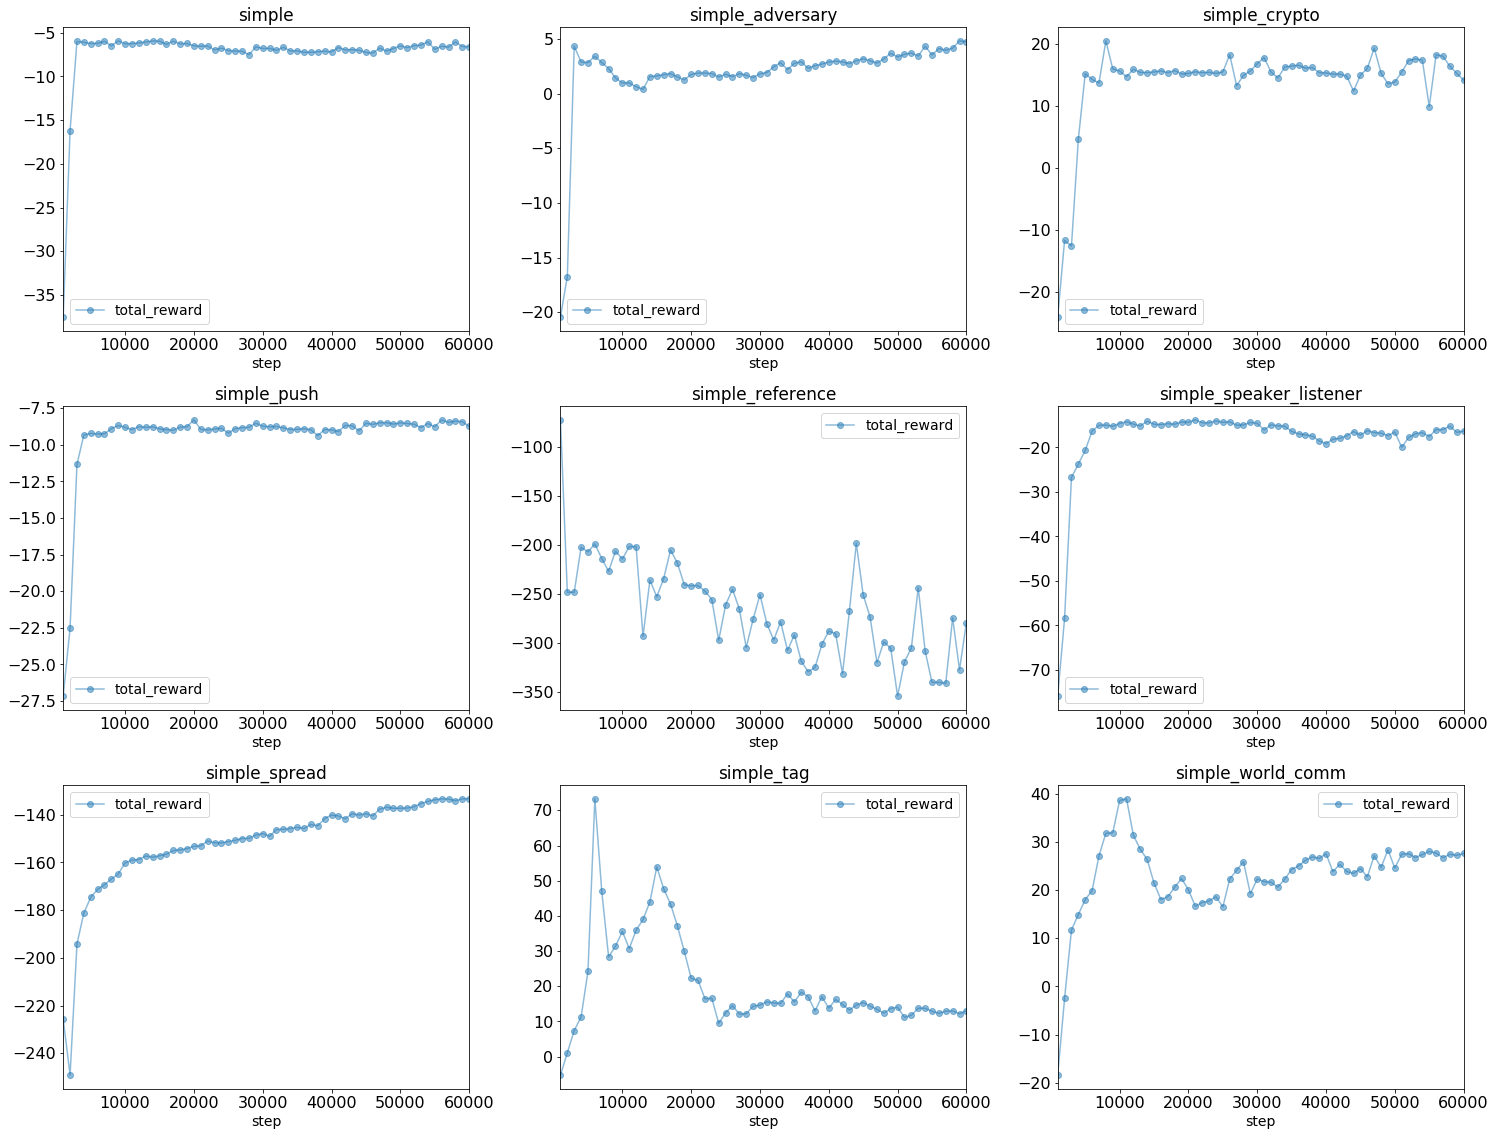

In [5]:
plot_lcs('rewards.csv',  colns=['step', 'total_reward'])

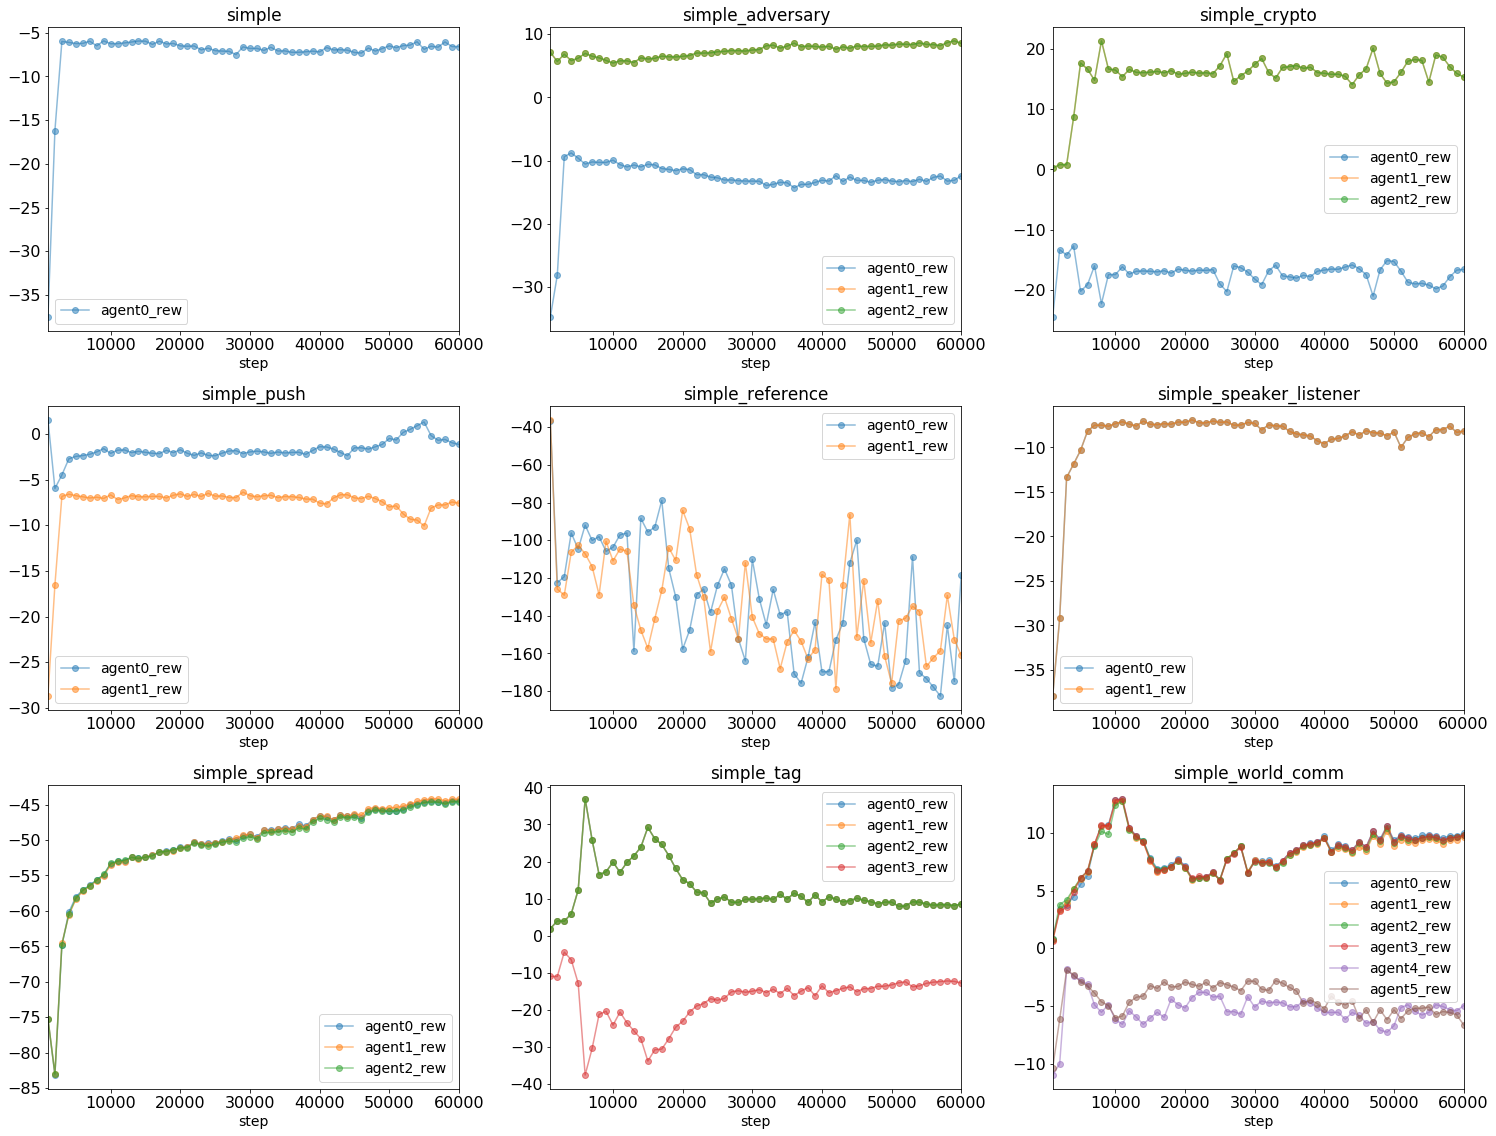

In [6]:
plot_lcs('agents_rewards.csv')

## 2. Each model results

### 2-1. simple
#### Setup
- a very simple structure (just for a test)
- world: 1 agent + 1 landmark
- obs: agent's v, relative vector to landmark
- act: 1dim（see below）
- reward: -1 x (distance between agent0 and landmark)

#### Expectation
- The agent moves to the landmark as fast as possible.

#### Results
- The model is trained as expected (see video).

In [7]:
scenario = 'simple'
action_space(scenario)
# <- no-move, left, right, down, up = 0, 1, 2, 3, 4
# Five discrete values for the agent

play_video(exp_dir, scenario, n_epi=60000)

[Discrete(5)]
./videos/exp_simple_13-03-2018_16-09-17/videos/video-60000.mp4


### 2-2. simple_adversary
#### Setup
- world: N good agents + 1 adversary + N landmark
    - here, N = 2
    - One of N landmarks is a goal for both good and adv agents.
- obs
    - good & adversary　agents:
        - positions of landamark + pos and vel of the agents
- act: 1dim x 3 agents
- reward:
    - The reward is the distance to the landmark.
    - Plus, the good agent gets a negative reward if the adv agent is close to the goal.
    - The good knows the goal landmark, but the adv cannot directly knows which landmarks are the goal.

#### Expectation
- If both good agents move to the goal, the adv implicitly know that the goal is the landmark which the good move to.
    - If the goal is known by adv, the total reward of good become small
- -> To increase the total reward, good deceieve the adv by two agents splitting to each landmark.
    - In this case, adv cannot know which landmark is the goal.
    - The adv will move to the middle point of both landmarks, which maximizes the expected adv's reward.

#### Results
- @3000epi: both good agents gather around the goal so that adv also move to the goal.
- @10,000epi: one of the good move to the goal, while the other acts awkwardly. Sometimes the latter deceives the adv.
- @60,000epi: The model is trained as expected (**learning to deceive**).

[Discrete(5), Discrete(5), Discrete(5)]
None


None

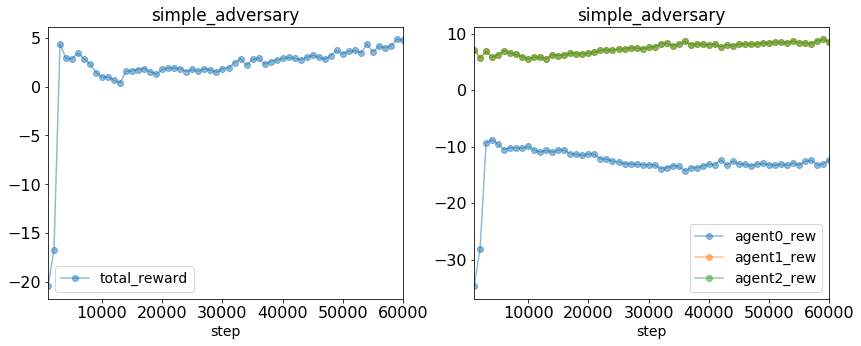

epi = 3000
./videos/exp_simple_adversary_13-03-2018_16-09-17/videos/video-3000.mp4


epi = 10000
./videos/exp_simple_adversary_13-03-2018_16-09-17/videos/video-10000.mp4


epi = 60000
./videos/exp_simple_adversary_13-03-2018_16-09-17/videos/video-60000.mp4


In [8]:
scenario = 'simple_adversary'
epis = [3000, 10000, 60000]

print(action_space(scenario)) # adversary, good1, good2
display(plot_each_lc(scenario))
plt.show()

for epi in epis:
    print('epi = %d' % epi)
    display(play_video(exp_dir, scenario, n_epi = epi))

### 2-3. simple_crypto

I couldn't display the resutls.... For now, just skip this scenario.

### 2-4. simple_push
#### Setup
- world
    - 1 good agent, 1 adversary (red), 2 landmarks (green and blue)
        - One of the landmarks is the goal, which is randomly chosen at every episode.
        - Only the good agent knows which landmark is the goal.
    - Both agents get a reward, when they are close to the goal.
    - adv gets negative reward when good is close to the goal.

#### Expectation
- Both agents move to the goal (adv can know from the good-agent movement)
- Plus, adv tries to prevent the good agent from getting close to the goal.

#### Results
- Event at 4000 epi, adv waits around the middle of the landmarks, 
    - and then follows the good agent move (**learning to follow**).
- adv pushes good to keep the goal away (**learning to push**).

[Discrete(5), Discrete(5)]
None


None

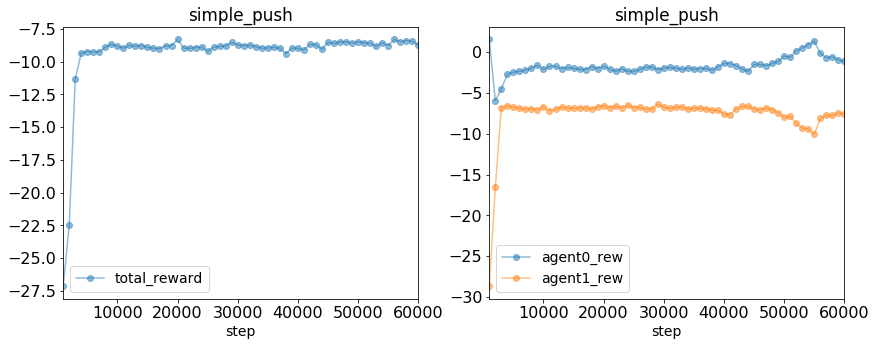

epi = 4000
./videos/exp_simple_push_13-03-2018_16-09-17/videos/video-4000.mp4


epi = 50000
./videos/exp_simple_push_13-03-2018_16-09-17/videos/video-50000.mp4


In [9]:
scenario = 'simple_push'
epis = [4000, 50000]

print(action_space(scenario))
display(plot_each_lc(scenario))
plt.show()

for epi in epis:
    print('epi = %d' % epi)
    display(play_video(exp_dir, scenario, n_epi = epi))


### 2-5. simple_reference

The agents didn't learn properly. For now, I won't investigate the cause (maybe later...).

[<gym.spaces.multi_discrete.MultiDiscrete object at 0x11edaa588>, <gym.spaces.multi_discrete.MultiDiscrete object at 0x11ed3eac8>]
None


None

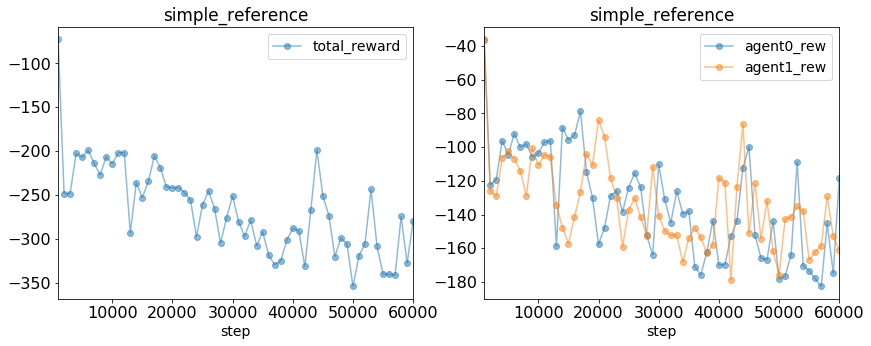

epi = 60000
./videos/exp_simple_reference_13-03-2018_16-09-16/videos/video-60000.mp4


In [10]:
scenario = 'simple_reference'
epis = [60000]

print(action_space(scenario))
display(plot_each_lc(scenario))
plt.show()

for epi in epis:
    print('epi = %d' % epi)
    display(play_video(exp_dir, scenario, n_epi = epi))

### 2-6. simple_speaker_listener
#### Setup
- 1 agent + 1 speaker + 3 landmarks
    - One of the 3 landmarks is the goal
    - agent and speaker get a reward, when agent is close to the goal.
        - agent doesn't know the goal.
        - speaker knows the goal but cannot move.

#### Expectation
- speaker teachs which landmark is the goal to agent.
- agent learn to "listen" to speaker and move to the goal.

#### Results
- Okay, almost as expected.
- speaker **learns to "speak"** the color of the goal (A=green, B=red, C=blue).
    - Note that it is a little unstable when the goal is green.

In [11]:
def _make_dic():
    import string
    abc = string.ascii_uppercase
    dic = dict(zip(abc, range(1, len(abc)+1)))
    dic['_'] = 0
    return dic

def to_case_val(case):
    dic = _make_dic()
    return dic[case]

def to_val_case(val):
    dic = _make_dic()
    dic_rev = dict([(v, k) for k, v in dic.items()])
    return dic_rev[val]

def get_df_messages(exp_dir, scenario, n_epi):
    each_exp_dir = get_exp_dir(exp_dir, scenario)
    fn_message = osp.join(each_exp_dir, 'videos/video-%d_messages.csv' % n_epi)
    
    df_msg = pd.read_csv(fn_message)
    for coln in df_msg.columns[:-2]:
        if np.all(df_msg[coln] == '_'):
            del df_msg[coln]
        else:
            df_msg[coln] = df_msg[coln].apply(to_case_val)
    return df_msg

def plot_messages(exp_dir, scenario, n_epi):
    df_msg = get_df_messages(exp_dir, scenario, n_epi)
    each_epis = sorted(df_msg.episode.unique())
    fig, axes = plt.subplots(1, len(each_epis), figsize=(7*len(each_epis), 5), sharey=True)

    yticks = range(int(df_msg.iloc[:, :-2].max()) + 1)
    for i, i_epi in enumerate(each_epis):
        ax = axes[i]
        df_msg.loc[df_msg.episode==i_epi, df_msg.columns != 'episode']\
            .plot(x='step', style='-o', ax=ax,
                     alpha=0.5, title='i_epi=%d' % i_epi)
        ax.set_yticks(yticks)
        ax.set_yticklabels([to_val_case(v) for v in yticks])
    plt.subplots_adjust(wspace=0.05, hspace=0)


[Discrete(3), Discrete(5)]
None


None

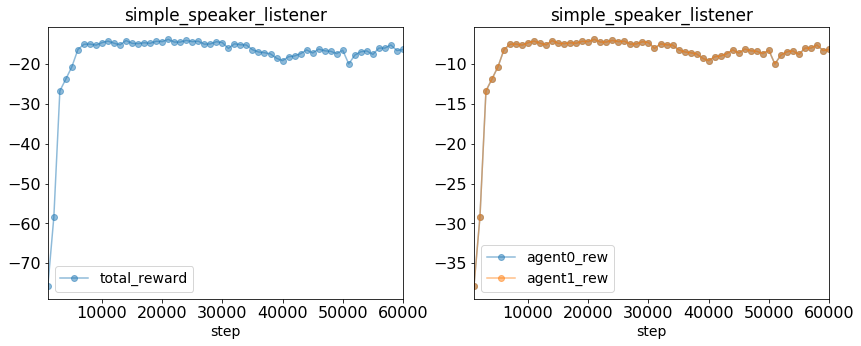

epi = 3000
./videos/exp_simple_speaker_listener_13-03-2018_16-09-16/videos/video-3000.mp4


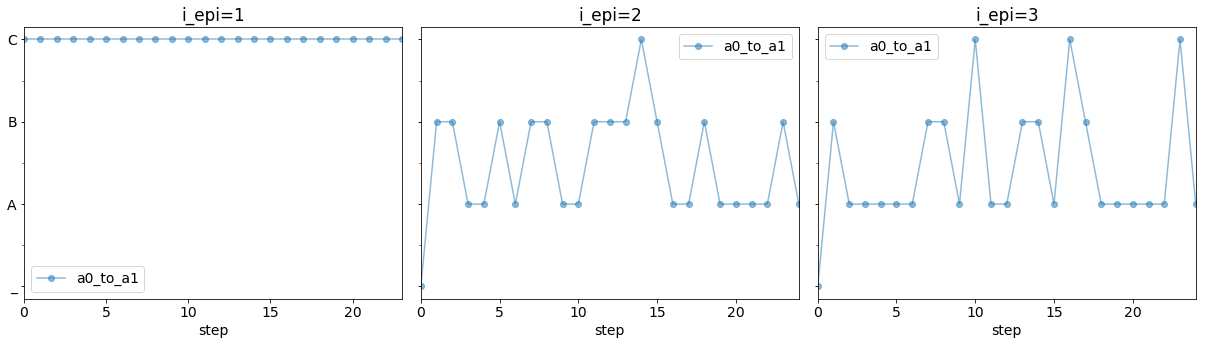

epi = 10000
./videos/exp_simple_speaker_listener_13-03-2018_16-09-16/videos/video-10000.mp4


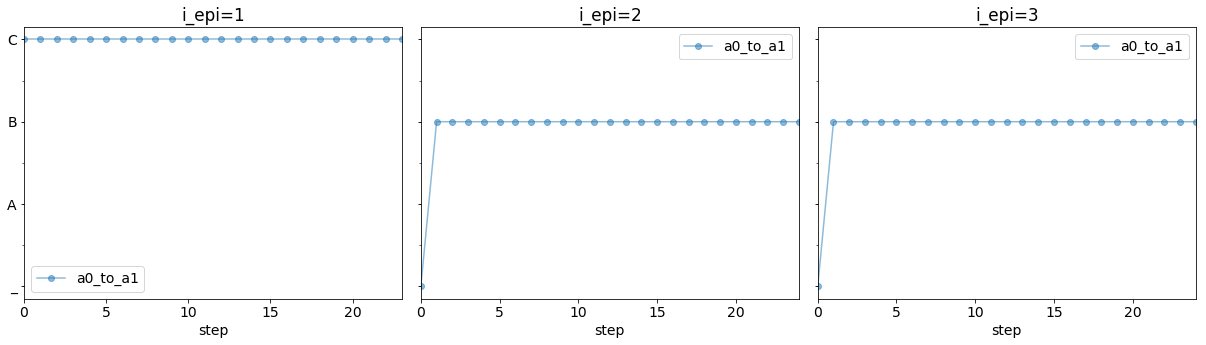

epi = 60000
./videos/exp_simple_speaker_listener_13-03-2018_16-09-16/videos/video-60000.mp4


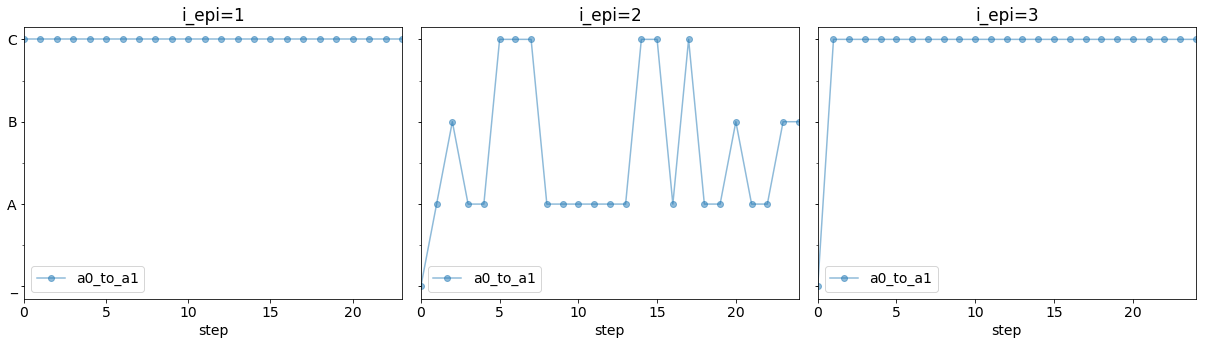

In [12]:
# The figures under the video show "character" of the speaker
# Each figure represent the each episode.
scenario = 'simple_speaker_listener'
epis = [3000, 10000, 60000]

print(action_space(scenario))
display(plot_each_lc(scenario))
plt.show()

for i, epi in enumerate(epis):
    print('epi = %d' % epi)
    display(play_video(exp_dir, scenario, n_epi = epi))
    plot_messages(exp_dir, scenario, epi)
    plt.show()

### 2-7. simple_spread
#### Setup
- 3 agnets, 3 landmarks (all landmarks are goals).
- The agent get reward, when it is close to the landmarks.

#### Expectation
- The agnets move to the landmarks.
- If they gather around one of the landmark, 
    - some agents cannot get close the goal so that they cannot get large reward.
- The most effcient way is that each agent occupies one landmark

#### Results
- 3000　epi: multiple agents get together.
- 10000 epi: agents start to spread.
- 30000 epi: agents learn to spread (but not smoothly).
- 60000　epi: agnets **learn to spread** smoothly.
As the training progresses, the agents learn to spread.  
One of the most beatiful results in experiment1.

Note that **learning to spread smoothly** means that agents **predict other agents' movement**.

[Discrete(5), Discrete(5), Discrete(5)]
None


None

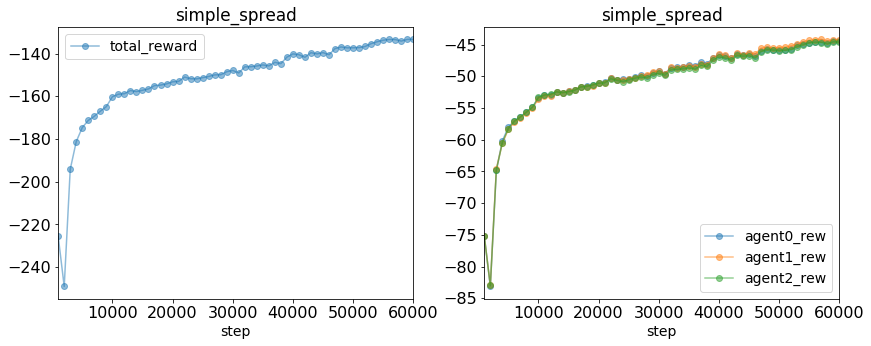

epi = 3000
./videos/exp_simple_spread_13-03-2018_16-09-18/videos/video-3000.mp4


epi = 10000
./videos/exp_simple_spread_13-03-2018_16-09-18/videos/video-10000.mp4


epi = 30000
./videos/exp_simple_spread_13-03-2018_16-09-18/videos/video-30000.mp4


epi = 60000
./videos/exp_simple_spread_13-03-2018_16-09-18/videos/video-60000.mp4


In [13]:
scenario = 'simple_spread'
epis = [3000, 10000, 30000, 60000]

print(action_space(scenario))
display(plot_each_lc(scenario))
plt.show()

for epi in epis:
    print('epi = %d' % epi)
    display(play_video(exp_dir, scenario, n_epi = epi))

### 2-8. simple_tag
#### Setup
- 3 predators (red), 1 prey (green), 2 obstacles 
    - predator get reward when they hit the prey.
    - prey get negative reward when it is hitted by predator. 
    - prey runs faster than predator.

#### Expectation
- Given that prey runs faster than predator, predator must learn the team play.

#### Results
- In the learning curve, the peaks around 5000 epi are due to predators learning to hit.
    - After they learn, their hits give the prey the negative rewards.
    - This push the prey to learn to escape.
    - So after some episodes, the absolute values of both rewards go down.
- After 30000 epi, it looks almost stable.
- 
- The episode lenght of 25 is short. 
    - At 2-8-2, I only extend the length for the display (traied model is fixed).
- 
- 3000 epi: unlearned
- 10,000 epi: prey runs away from the predator.
- 20,000 epi: predator start to hit the prey.
    - 1 or 2 red agents finally chase the green agent (not all).
- 60,000 epi: no strong difference from 20,000

#### Discussion
- Even at 60,000 epi, each predator run after the prey and do not learn a team play.
    - This is probably because max_epi_len of 25 is too short to observe.
    - max_epi_len should be longer during the training (-> ana_exp2.ipynb).


[Discrete(5), Discrete(5), Discrete(5), Discrete(5)]
None


None

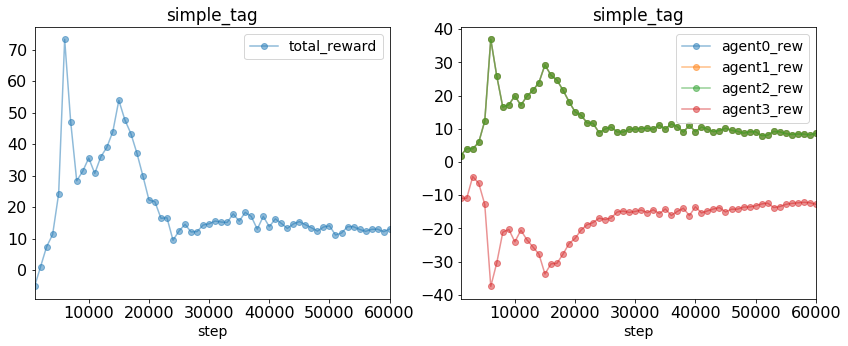

epi = 3000
./videos/exp_simple_tag_13-03-2018_16-09-17/videos/video-3000.mp4


epi = 10000
./videos/exp_simple_tag_13-03-2018_16-09-17/videos/video-10000.mp4


epi = 20000
./videos/exp_simple_tag_13-03-2018_16-09-17/videos/video-20000.mp4


epi = 60000
./videos/exp_simple_tag_13-03-2018_16-09-17/videos/video-60000.mp4


In [14]:
scenario = 'simple_tag'
epis = [3000, 10000, 20000, 60000]

print(action_space(scenario))
display(plot_each_lc(scenario))
plt.show()

for epi in epis:
    print('epi = %d' % epi)
    display(play_video(exp_dir, scenario, n_epi = epi))

### 2-8-2; setup2 (max_epi_len=25 -> 200 for videos)

In [15]:
fn_template = './videos/exp_simple_tag_13-03-2018_16-09-17/videos/video-{}_epi-len200.mp4'
for epi in epis:
    fn_video = fn_template.format(epi)
    display(_play_video(fn_video))
#     break

./videos/exp_simple_tag_13-03-2018_16-09-17/videos/video-3000_epi-len200.mp4


./videos/exp_simple_tag_13-03-2018_16-09-17/videos/video-10000_epi-len200.mp4


./videos/exp_simple_tag_13-03-2018_16-09-17/videos/video-20000_epi-len200.mp4


./videos/exp_simple_tag_13-03-2018_16-09-17/videos/video-60000_epi-len200.mp4


### 2-9. simple_world_comm
#### Setup
- 2 preys, 4 predators (1 leader + 3 followers),
    - + 2 blue circles: food, which the preys get reward when it is close to,
    - + 2 forests where the preys are unvisible from 3 follower predators,
    - + 1 obstacle.
- leader predator can speak to the followers.
 - The communication way is 4-dimention values (here denoted as A, B, C and D).

#### Expectation
- The setup is so complicated that it is difficult to expect clearly.
- predator will porbably hunt following the leader.
- prey will run using the forest.

#### Results
In the learning curve, the reason of the first peaks around 10,000 epi is the same as "simple_tag".

The 2-9-2 results show that the predators don't chase the prey efficiently.  
Mostly they just chase the prey and there seems no advanced tactics:  
pincers movement, ambush, etc.

The predators split into two to chase two green agents. This tactics seems  
bad: two-vs-one chase seems inefficient. I guess that it is better tacitics   
to chase one agent with more predators.

#### Discussion
The learned tactics results from the short-period learning (max_epi_len = 25).  
In this case, the above tactics may be good; there is little time to hit prey so that  
the predators just chase the closest prey.  

What we want to see is that agents learn tactics to chase and escape.  
max_epi_len = 25 seems too short to learn such a tactics. max_epi_len should  
be longer during the training (-> ana_exp3.ipynb).

[<gym.spaces.multi_discrete.MultiDiscrete object at 0x11ebecd68>, Discrete(5), Discrete(5), Discrete(5), Discrete(5), Discrete(5)]
None


None

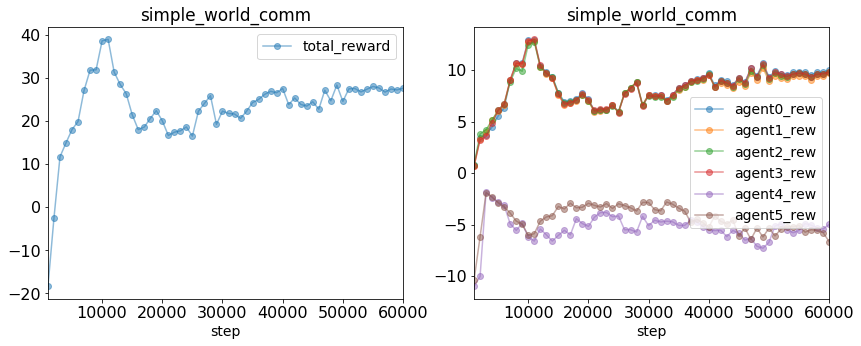

epi = 3000
./videos/exp_simple_world_comm_13-03-2018_16-09-17/videos/video-3000.mp4


epi = 10000
./videos/exp_simple_world_comm_13-03-2018_16-09-17/videos/video-10000.mp4


epi = 30000
./videos/exp_simple_world_comm_13-03-2018_16-09-17/videos/video-30000.mp4


epi = 60000
./videos/exp_simple_world_comm_13-03-2018_16-09-17/videos/video-60000.mp4


In [16]:
scenario = 'simple_world_comm'
epis = [3000, 10000, 30000, 60000]

print(action_space(scenario))
display(plot_each_lc(scenario))
plt.show()

for epi in epis:
    print('epi = %d' % epi)
    display(play_video(exp_dir, scenario, n_epi = epi))

### 2-9-2; setup2 (max_epi_len=25 -> 200 for videos)


In [17]:
def _make_dic():
    import string
    abc = string.ascii_uppercase
    dic = dict(zip(abc, range(1, len(abc)+1)))
    dic['_'] = 0
    return dic

def to_case_val(case):
    dic = _make_dic()
    return dic[case]

def to_val_case(val):
    dic = _make_dic()
    dic_rev = dict([(v, k) for k, v in dic.items()])
    return dic_rev[val]

def get_df_messages2(fn_video):
    fn_message = fn_video.replace('.mp4', '_messages.csv')
    df_msg = pd.read_csv(fn_message)
    for coln in df_msg.columns[:-2]:
        if np.all(df_msg[coln] == '_'):
            del df_msg[coln]
        else:
            df_msg[coln] = df_msg[coln].apply(to_case_val)
    return df_msg

def plot_messages2(fn_video):
    df_msg = get_df_messages2(fn_video)
    each_epis = sorted(df_msg.episode.unique())
    fig, axes = plt.subplots(1, len(each_epis), figsize=(7*len(each_epis), 5), sharey=True)

    yticks = range(int(df_msg.iloc[:, :-2].values.max()) + 1)
    for i, i_epi in enumerate(each_epis):
        ax = axes[i]
        df_msg.loc[df_msg.episode==i_epi, df_msg.columns != 'episode']\
            .plot(x='step', style='-o', ax=ax,
                     alpha=0.5, title='i_epi=%d' % i_epi)
        ax.set_yticks(yticks)
        ax.set_yticklabels([to_val_case(v) for v in yticks])
    plt.subplots_adjust(wspace=0.05, hspace=0)

./videos/exp_simple_world_comm_13-03-2018_16-09-17/videos/video-60000_epi-len200.mp4


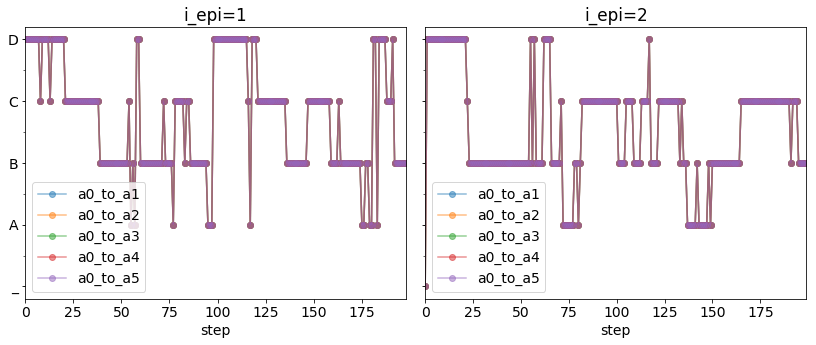

In [18]:
fn_template = './videos/exp_simple_world_comm_13-03-2018_16-09-17/videos/video-{}_epi-len200.mp4'
epis = [60000]

for epi in epis:
    fn_video = fn_template.format(epi)
    display(_play_video(fn_video))
    plot_messages2(fn_video)
    plt.show()